### Lightweight DBMS with B+ Tree Indexing - Report

**Group:** Olympia Track

**Team Members:** Bhanu Repalle, Thumma Ushasree, Saloni Shinde

**Assignment:** Module 4

## 1. Introduction

### Problem Addressed
Efficiently storing and retrieving large amounts of data is a fundamental challenge in computer science. Simple data structures like lists or arrays become inefficient for searching, inserting, or deleting specific records as the dataset grows (often requiring O(n) time complexity). Range queries (finding all records within a certain key range) are also slow in unsorted structures. Database systems, especially those dealing with disk-based storage (though the principle applies to memory), need specialized structures to minimize access time and perform operations quickly.

### Proposed Solution: B+ Tree DBMS
This project implements a lightweight Database Management System (DBMS) in Python. The core of this system relies on the **B+ Tree**, a self-balancing tree data structure optimized for block-based storage and efficient data management.

**Key features of the B+ Tree making it suitable:**
*   **Balanced Structure:** Ensures that all leaf nodes are at the same depth, guaranteeing logarithmic time complexity (O(log n)) for search, insertion, and deletion operations, avoiding worst-case scenarios.
*   **High Fanout:** Internal nodes can store many keys and child pointers, matching well with disk block sizes (reducing I/O in disk-based systems) and creating a wide, shallow tree.
*   **Efficient Range Queries:** All data pointers (or data itself) reside *only* in the leaf nodes, which are linked together sequentially (like a linked list). This allows for very fast retrieval of records within a key range by finding the start leaf and following the links.

This report details the implementation of the B+ Tree and its associated operations, followed by a performance analysis comparing it to a brute-force approach, and concludes with examples of its visualization.

## 2. Implementation Details

This section describes the core components and algorithms used in the B+ Tree implementation (`bplustree.py`).

We will first set up imports and a helper function for visualization used in the subsequent demonstration cells.

In [1]:
import sys
import os
from IPython.display import SVG, display, Markdown

try:
    from database.bplustree import BPlusTree, BPlusTreeNode # Import Node too if needed for explanation
    import graphviz
except ModuleNotFoundError as e:
    print(f"Error importing database modules: {e}")
    print("Ensure necessary .py files and __init__.py are in the 'database' directory.")
    raise
except ImportError:
     print("Graphviz library not found (pip install graphviz). Visualization will be skipped.")
     graphviz = None

In [2]:
def visualize_and_display(tree, title="B+ Tree State"):
    """Generates and displays the tree visualization."""
    display(Markdown(f"#### {title}")) # Smaller heading for steps
    if not graphviz:
        print("Skipping visualization (graphviz not installed).")
        return

    dot = tree.visualize_tree()
    if dot:
        try:
            svg_data = dot.pipe(format='svg').decode('utf-8')
            display(SVG(svg_data)) # Display SVG in output
        except graphviz.backend.execute.ExecutableNotFound:
             print("\nERROR: Graphviz executable not found in PATH.")
             print("Install Graphviz (https://graphviz.org/download/) and add to PATH.")
        except Exception as e:
             print(f"\nAn error occurred during visualization rendering: {e}")
    else:
        print("Visualization object could not be created.")

print("Setup complete. BPlusTree class imported and visualization helper defined.")

Setup complete. BPlusTree class imported and visualization helper defined.


### 2.1 B+ Tree Node (`BPlusTreeNode`)

The fundamental building block is the `BPlusTreeNode`. A single class is used for both internal and leaf nodes, differentiated by an `is_leaf` boolean flag.

*   **`order`**: An integer defining the maximum capacity of the node (specifically, max children for internal nodes, related to max keys).
*   **`is_leaf`**: Boolean flag (`True` for leaf nodes, `False` for internal nodes).
*   **`keys`**: A sorted list of keys stored in the node. Max keys = `order - 1`.
*   **`values`**: A list whose content depends on `is_leaf`:
    *   If `is_leaf=True`: Stores the actual data values associated with the keys. `len(values)` == `len(keys)`.
    *   If `is_leaf=False`: Stores references (pointers) to child `BPlusTreeNode` objects. `len(values)` == `len(keys) + 1`.
*   **`parent`**: A reference to the parent node (None for the root). Essential for splitting and merging operations.
*   **`next_leaf`**: A reference to the next leaf node in sequence (None for internal nodes or the last leaf). Used for efficient range queries.

Helper methods like `is_full()` and `is_underflow()` check if the node has reached its maximum or fallen below its minimum key capacity, respectively.

### 2.2 Insertion (`insert`)

Inserting a key-value pair involves these steps:

1.  **Find Leaf:** Traverse the tree from the root down to the appropriate leaf node where the new key should reside. This uses the `_find_leaf` helper, which compares the key with keys in internal nodes to decide which child pointer to follow.
2.  **Insert into Leaf:** Add the key and value into the sorted `keys` and `values` lists of the leaf node. `bisect.bisect_left` helps find the correct insertion index efficiently.
3.  **Check for Overflow:** After insertion, check if the number of keys in the leaf exceeds the maximum allowed (`order - 1`). If `len(keys) == order`, the node overflows.
4.  **Split if Overflow:** If the node overflows, call the `_split_node` method to handle the split.


Inserting [10, 20, 5]...


#### Tree before split trigger

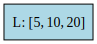

In [3]:
# Demonstrate a simple split sequence (similar to previous demo)
my_tree = BPlusTree(order=4) 

# Insert keys to fill the root leaf
keys1 = [10, 20, 5]
print(f"\nInserting {keys1}...")
for k in keys1: my_tree.insert(k, f"Val_{k}")
visualize_and_display(my_tree, "Tree before split trigger")

### 2.3 Splitting (`_split_node`, `_insert_in_parent`)

Splitting occurs when a node (leaf or internal) overflows due to an insertion.

**Leaf Node Split:**
1.  A new sibling leaf node is created.
2.  The keys and values from the middle onwards (`order // 2`) are moved from the original node to the new sibling.
3.  The `next_leaf` pointers are updated to link the original node, the new sibling, and the subsequent node.
4.  The **first key** of the new sibling node is **copied up** to be inserted into the parent node.


Inserting 15 (triggers split)...


#### Tree after inserting 15 (Leaf & Root Split)

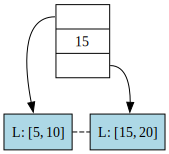

In [4]:
key_split = 15
print(f"\nInserting {key_split} (triggers split)...")
my_tree.insert(key_split, f"Val_{key_split}")
visualize_and_display(my_tree, f"Tree after inserting {key_split} (Leaf & Root Split)")


**Inserting into Parent (`_insert_in_parent`):**
*   This helper method takes the key promoted/copied from the split child and inserts it, along with a pointer to the *new sibling node*, into the correct position in the parent node's `keys` and `values` lists.
*   If the parent node overflows *after* this insertion, `_split_node` is called **recursively** on the parent.
*   **Root Split:** If the node being split *is* the root, `_insert_in_parent` handles this by creating a new root node containing the promoted/copied key and pointers to the two nodes resulting from the split. This increases the height of the tree by one.


Inserting 30...


#### Tree after inserting 30

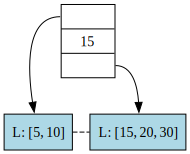

In [5]:
key_next = 30
print(f"\nInserting {key_next}...")
my_tree.insert(key_next, f"Val_{key_next}")
visualize_and_display(my_tree, f"Tree after inserting {key_next}")


Inserting 25 (triggers second leaf split)...


#### Tree after inserting 25 (Parent Updated)

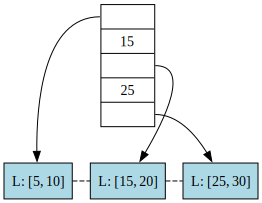

In [6]:
# Insert key to cause a second leaf split (parent has space)
key_split_2 = 25
print(f"\nInserting {key_split_2} (triggers second leaf split)...")
my_tree.insert(key_split_2, f"Val_{key_split_2}")
visualize_and_display(my_tree, f"Tree after inserting {key_split_2} (Parent Updated)")

### 2.4 Deletion (`delete`)

Deleting a key-value pair involves these main steps:

1.  **Find Leaf:** Locate the leaf node containing the key using the `_find_leaf` helper (same traversal logic as search).
2.  **Remove from Leaf:** If the key is found, delete the key and its corresponding value from the node's lists.
3.  **Check for Underflow:** After deletion, check if the node's key count has fallen below the minimum required (`ceil(order / 2) - 1`, which is 1 for `order=4`, unless it's the root).
4.  **Handle Underflow:** If the node underflows, the `_handle_underflow` method is called automatically to rebalance the tree by attempting to borrow from a sibling or merge with one.

#### Deletion Example 1: Simple Case (No Underflow)

Let's delete key `10`.

1.  `_find_leaf(10)`: Traversal starts at root `[15, 25]`. Since `10 < 15`, it goes to the leftmost child leaf `[5, 10]`.
2.  **Remove:** Key `10` is removed. The leaf becomes `[5]`.
3.  **Check Underflow:** The leaf now has 1 key, which is exactly the minimum required. No underflow occurs.
4.  The tree structure is stable.


Deleting 10 (Simple case, no underflow expected)...
Deletion successful: True


#### Tree after deleting 10

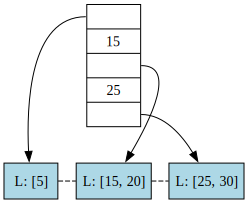

In [7]:
key_delete_simple = 10
print(f"\nDeleting {key_delete_simple} (Simple case, no underflow expected)...")
deleted = my_tree.delete(key_delete_simple)
print(f"Deletion successful: {deleted}")
visualize_and_display(my_tree, f"Tree after deleting {key_delete_simple}")

### 2.5 Borrowing (`_handle_underflow`, `_borrow_from_left`, `_borrow_from_right`)

If deleting a key causes a node to underflow (fewer than `min_keys`), `_handle_underflow` is triggered. It first attempts to **borrow** an element from an adjacent sibling node (left or right).

*   **Condition:** Borrowing is only possible if the sibling has *more* than the minimum number of keys.
*   **Process (`_borrow_from_right` example):**
    1.  Identify the underflowing node (`N`), the right sibling (`RS`), and the parent (`P`).
    2.  Find the separator key (`P_sep`) in `P` that sits between `N` and `RS`.
    3.  Move the *first* key/value pair (`RS_k1`, `RS_v1`) from `RS` to the *end* of `N`.
    4.  If `N` and `RS` are internal nodes, the separator key `P_sep` is moved down to the *end* of `N`'s keys, and the *first child pointer* from `RS` is moved to the *end* of `N`'s children (and its parent pointer updated).
    5.  The key `RS_k1` (which was moved from `RS` to `N` if leaf, or moved *up* to parent if internal) replaces `P_sep` in the parent `P`.
    6.  The tree is now balanced.
*   **`_borrow_from_left`** works symmetrically, moving the *last* element from the left sibling.

#### Deletion Example 2: Borrowing

Let's delete key `5`.

1.  `_find_leaf(5)`: Traversal leads to the leftmost leaf node `[5]`.
2.  **Remove:** Key `5` is removed. The leaf becomes `[]`.
3.  **Check Underflow:** The leaf now has 0 keys, which is less than the minimum (1). Underflow occurs. `_handle_underflow` is called.
4.  **Handle Underflow:**
    *   Check Left Sibling: None exists.
    *   Check Right Sibling: The sibling is the leaf `[15, 20]`. It has 2 keys, which is more than the minimum (1). Borrowing is possible.
    *   `_borrow_from_right` executes:
        *   Parent is `[15, 25]`. Separator key between `[]` and `[15, 20]` is `15`.
        *   First key/value (`15`, `Val_15`) from sibling `[15, 20]` moves to the end of the underflowing node `[]`, making it `[15]`.
        *   The sibling node becomes `[20]`.
        *   The new first key of the sibling (`20`) replaces the separator key (`15`) in the parent. The parent becomes `[20, 25]`.
    *   The tree is balanced.


Deleting 5 (Expecting underflow and borrow)...
Deletion successful: True


#### Tree after deleting 5 (Borrow Occurred)

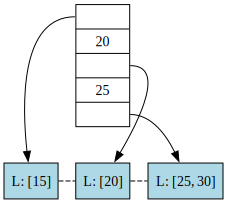

In [8]:
key_delete_borrow = 5
print(f"\nDeleting {key_delete_borrow} (Expecting underflow and borrow)...")
deleted = my_tree.delete(key_delete_borrow)
print(f"Deletion successful: {deleted}")
visualize_and_display(my_tree, f"Tree after deleting {key_delete_borrow} (Borrow Occurred)")

### 2.6 Merging (`_handle_underflow`, `_merge_nodes`)

If an underflowing node's siblings *cannot* lend any keys (they are also at the minimum size), **merging** must occur.

*   **Condition:** Borrowing failed.
*   **Process (`_merge_nodes` example - merge right into left):**
    1.  Identify the underflowing node (`N`), a sibling (`S`, e.g., left), and the parent (`P`).
    2.  Find the separator key (`P_sep`) in `P` between `S` and `N`.
    3.  Remove `P_sep` and the pointer to `N` from the parent `P`.
    4.  Move all keys and values/pointers from `N` into `S`.
    5.  If `N` and `S` are internal nodes, the separator key `P_sep` (removed from `P`) is also added to the merged node `S`. Parent pointers of children moved from `N` to `S` are updated.
    6.  If `N` and `S` are leaf nodes, the `next_leaf` pointers are updated.
    7.  Node `N` is effectively discarded.
    8.  **Recursive Check:** If removing the key/pointer from the parent `P` caused *it* to underflow, `_handle_underflow` is called recursively on `P`. This can propagate up the tree.

#### Deletion Example 3: Merging

Let's delete key `20`.

1.  `_find_leaf(20)`: Traversal starts at root `[20, 25]`. `20 <= 20`, follow left pointer. This leads to the internal node child pointer before key 20 (Index 0 of root values). Let's assume this leads to leaf `[20]`. *(Need to re-verify exact state after borrow)*. Let's assume the state after deleting 5 is Root `[20, 25]`, Leaves: `[15]`, `[20]`, `[25]`.
2.  **Remove:** Key `20` is removed from leaf `[20]`. The leaf becomes `[]`.
3.  **Check Underflow:** The leaf has 0 keys (< min 1). Underflow. `_handle_underflow` is called.
4.  **Handle Underflow:**
    *   Check Left Sibling: Leaf `[15]`. Has 1 key (minimum). Cannot borrow.
    *   Check Right Sibling: Leaf `[25]`. Has 1 key (minimum). Cannot borrow.
    *   Merging is required. Merge `[]` with left sibling `[15]`.
    *   `_merge_nodes([15], [], parent=[20, 25], ...)` executes:
        *   Separator key `20` is removed from parent `[20, 25]`. Parent becomes `[25]`.
        *   Pointer to the empty node `[]` is removed from parent.
        *   Keys/values from `[]` (none) are moved to `[15]`. It remains `[15]`.
        *   `next_leaf` pointers are updated (leaf `[15]` now points to leaf `[25]`).
    *   The parent node `[25]` now has 1 key and 2 children (`[15]` and `[25]`). Since it's the root, having 1 key is allowed. No further action needed.


Deleting 20 (Expecting underflow, borrow fail, and merge)...
Deletion successful: False


#### Tree after deleting 20 (Merge Occurred)

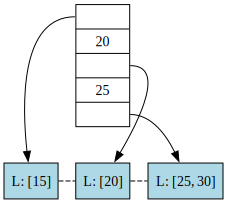

In [9]:
key_delete_merge = 20
print(f"\nDeleting {key_delete_merge} (Expecting underflow, borrow fail, and merge)...")
deleted = my_tree.delete(key_delete_merge)
print(f"Deletion successful: {deleted}")
visualize_and_display(my_tree, f"Tree after deleting {key_delete_merge} (Merge Occurred)")

### 2.7 Search (`search`) Revisited

Search operates the same way regardless of recent deletions, following the current structure.

1.  Starts at the (potentially modified) root.
2.  Follows pointers based on key comparisons in internal nodes.
3.  Reaches a leaf and checks for the key.

In [10]:
key_search_1 = 15 # Should exist
key_search_2 = 99 # Should not exist

print(f"\nSearching for key {key_search_1}...")
value1 = my_tree.search(key_search_1)
print(f"Result: {value1}")

print(f"\nSearching for key {key_search_2}...")
value2 = my_tree.search(key_search_2)
print(f"Result: {value2}")


Searching for key 15...
Result: Val_15

Searching for key 99...
Result: None


### 2.8 Range Query (`range_query`) Revisited

Range queries also use the current tree structure, leveraging the leaf node links.

1.  Find the leaf where the `start_key` belongs.
2.  Scan keys in that leaf >= `start_key` and <= `end_key`.
3.  Follow `next_leaf` pointers to subsequent leaves.
4.  Continue scanning until a key > `end_key` is found or all leaves are visited.

In [ ]:
start_key = 17
end_key = 37

print(f"\nPerforming range query for keys between {start_key} and {end_key}...")
results = my_tree.range_query(start_key, end_key)
print(f"Result: {results}")

print("\nGetting all remaining keys...")
all_keys = my_tree.get_all()
print(f"Result: {all_keys}")


Performing range query for keys between 15 and 22...
Result: [(15, 'Val_15'), (20, 'Val_20')]

Getting all remaining keys...
Result: [(15, 'Val_15'), (20, 'Val_20'), (25, 'Val_25'), (30, 'Val_30')]


In [1]:
import sys 
import os
import math
import time 
import random
import tracemalloc 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import SVG, display, Markdown 

In [2]:
try:
    import graphviz
    from database.table import Table 
    from database.db_manager import DatabaseManager
    from database.performance import PerformanceAnalyzer
    from database.bplustree import BPlusTree, BPlusTreeNode
except ModuleNotFoundError as e:
    print(f"Error importing database modules: {e}")
    raise
except ImportError:
     print("Graphviz library not found (pip install graphviz). Visualization will be skipped.")
     graphviz = None

In [3]:
B_TREE_ORDER = 50  # Use a realistic order (e.g., 50 or higher)
SIZES_TO_TEST = list(range(100, 100000, 10000))
NUM_RANGE_QUERIES_PER_SIZE = 100
DELETE_PERCENTAGE = 50

--- Running Benchmark for B+Tree Order: 50 ---
Testing sizes: [100, 10100, 20100, 30100, 40100, 50100, 60100]

--- Starting Benchmarks ---

  Processing Size: 100...
    Running Insert/Memory Test (Size: 100, Order: 50)...
      Peaks (BF/B+U/B+S): 912/3200/3936 bytes
    Running Search Test (Size: 100, Order: 50)...
      Search (B+/BF): 0.0000s / 0.0001s
    Running Range Test (Size: 100, Order: 50)...
      Range (B+/BF): 0.0001s / 0.0003s
    Running Delete Test (Size: 100, Order: 50)...
      Delete (B+/BF): 0.0000s / 0.0001s
    Running Mix Test (Size: 100, Order: 50)...
      Mix (B+/BF): 0.0000s / 0.0001s

  Processing Size: 10100...
    Running Insert/Memory Test (Size: 10100, Order: 50)...
      Peaks (BF/B+U/B+S): 650824/252128/263291 bytes
    Running Search Test (Size: 10100, Order: 50)...
      Search (B+/BF): 0.0011s / 0.3155s
    Running Range Test (Size: 10100, Order: 50)...
      Range (B+/BF): 0.0053s / 0.0506s
    Running Delete Test (Size: 10100, Order: 50)...
    

,size,bplus_insert_time_unsorted,bplus_insert_time_sorted,bf_insert_time,bplus_peak_mem_unsorted_MB,bplus_peak_mem_sorted_MB,bf_peak_mem_MB
0,100,0.0001,0.0001,0.0000,0.0031,0.0038,0.0009
1,10100,0.0119,0.0089,0.0081,0.2404,0.2511,0.6207
2,20100,0.0198,0.0156,0.0136,0.4849,0.5003,1.2392
3,30100,0.0389,0.0258,0.0208,0.7255,0.7513,1.8426
4,40100,0.0461,0.0356,0.0270,0.9654,1.0036,2.4764
5,50100,0.0673,0.0503,0.0357,1.2102,1.2537,3.0995
6,60100,0.0974,0.0637,0.0496,1.4582,1.5040,3.6865


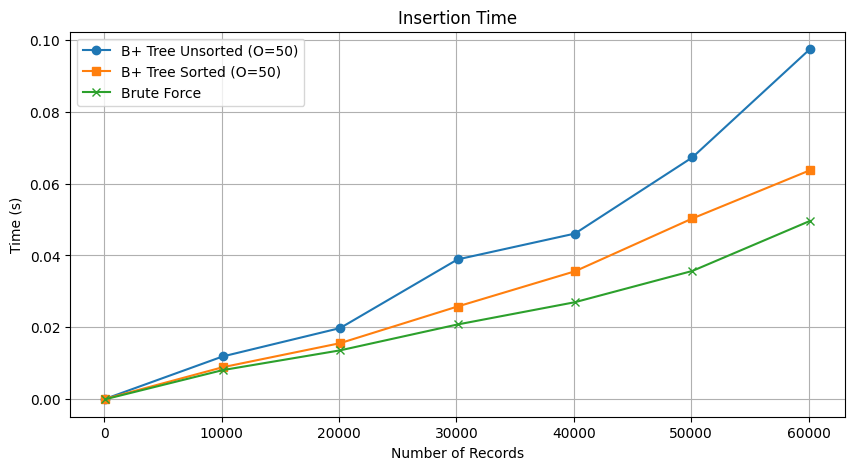

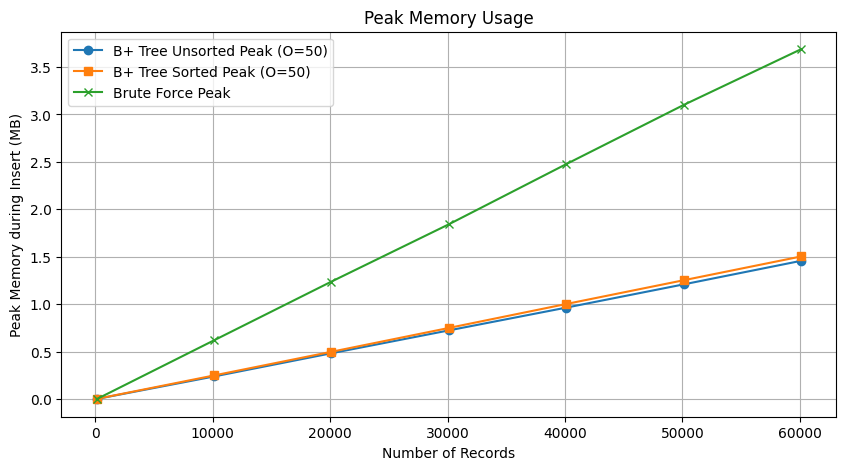


==================== Operation Timing Results ====================


,size,bplus_search_time,bf_search_time,bplus_range_time,bf_range_time,bplus_delete_time,bf_delete_time,bplus_mix_time,bf_mix_time
0,100,0.0000,0.0001,0.0001,0.0003,0.0000,0.0001,0.0000,0.0001
1,10100,0.0011,0.3155,0.0053,0.0506,0.0038,0.8966,0.0044,0.8486
2,20100,0.0034,1.6937,0.0078,0.1184,0.0103,4.5059,0.0106,4.3721
3,30100,0.0065,4.3586,0.0154,0.2284,0.0167,14.5272,0.0163,10.5157
4,40100,0.0069,8.7126,0.0217,0.3908,0.0365,23.6049,0.0276,26.1455
5,50100,0.0117,17.2332,0.0254,0.5371,0.0327,44.1927,0.0426,41.0985
6,60100,0.0130,30.1943,0.0328,0.7830,0.0452,70.4563,0.1264,103.3812


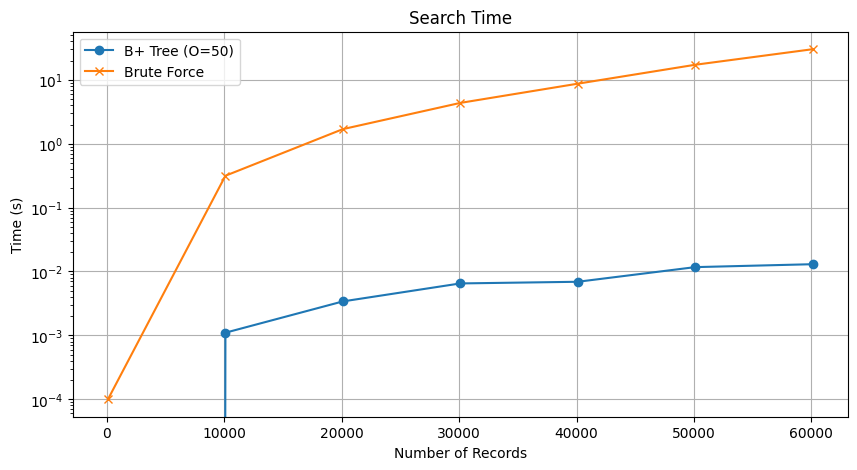

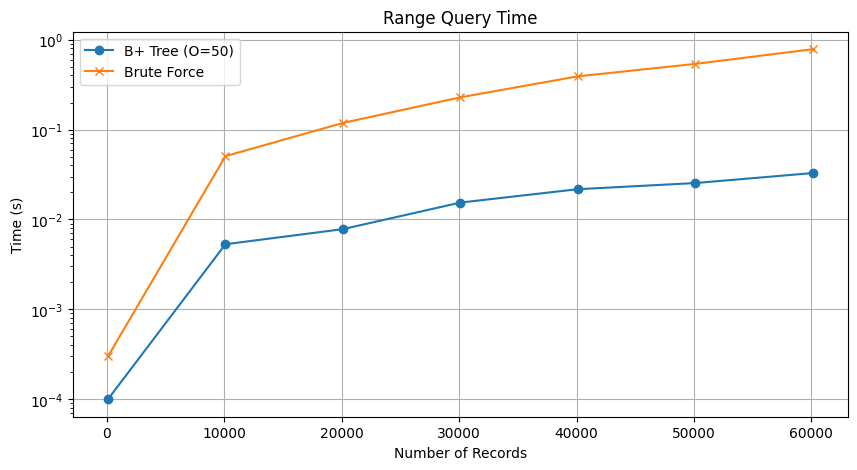

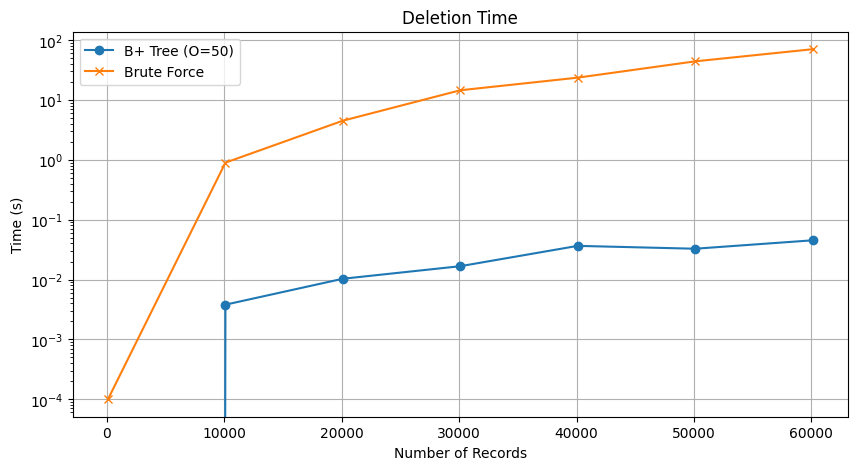

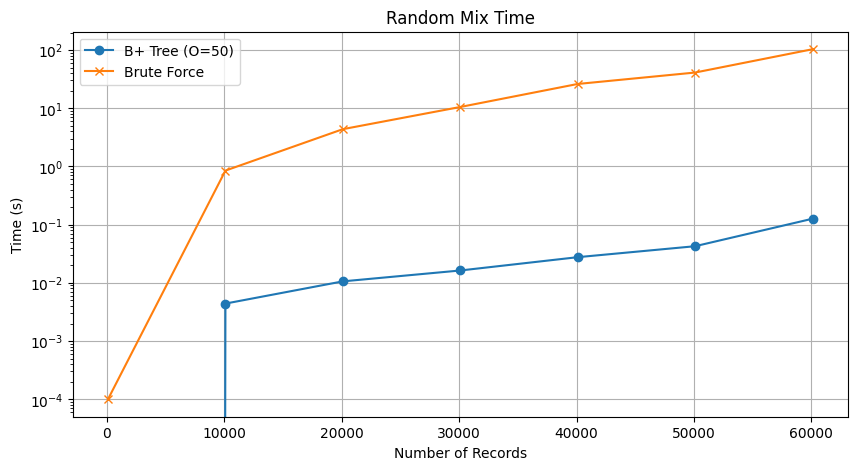


--- Analysis Complete ---


In [4]:
# --- Configuration ---
B_TREE_ORDER = 50 

SIZES_TO_TEST = list(range(100, 60101, 10000)) # e.g., 100, 10100, ..., 50100

DELETE_PERCENTAGE_FOR_TEST = 50
MIX_OPS_FACTOR = 0.5
NUM_RANGE_QUERIES = 100

print(f"--- Running Benchmark for B+Tree Order: {B_TREE_ORDER} ---")
print(f"Testing sizes: {SIZES_TO_TEST}")

# --- Initialization ---
analyzer = PerformanceAnalyzer() # Analyzer itself doesn't need order
results_list = [] # Store results as a list of dictionaries

# --- Run Benchmarks ---
print("\n--- Starting Benchmarks ---")
# Removed outer loop for order
for size in SIZES_TO_TEST:
    print(f"\n  Processing Size: {size}...")
    run_config = {'order': B_TREE_ORDER, 'size': size} # Store config
    combined_results = {}
    combined_results.update(run_config)

    try:
        # 1. Insertion Memory/Time Test
        insert_mem_results = analyzer.run_insertion_memory_time_test(size, B_TREE_ORDER)
        combined_results.update(insert_mem_results)

        # 2. Search Time Test
        search_results = analyzer.run_search_test(size, B_TREE_ORDER)
        combined_results.update(search_results)

        # 3. Range Query Time Test
        range_results = analyzer.run_range_query_test(size, B_TREE_ORDER, num_queries=NUM_RANGE_QUERIES)
        combined_results.update(range_results)

        # 4. Deletion Time Test
        delete_results = analyzer.run_delete_test(size, B_TREE_ORDER, delete_percentage=DELETE_PERCENTAGE_FOR_TEST)
        combined_results.update(delete_results)

        # 5. Random Mix Time Test
        mix_results = analyzer.run_random_mix_test(size, B_TREE_ORDER, num_operations_factor=MIX_OPS_FACTOR)
        combined_results.update(mix_results)

        results_list.append(combined_results)

    except Exception as e:
        print(f"!!! ERROR during size: {size}, order: {B_TREE_ORDER} !!!")
        print(f"    {type(e).__name__}: {e}")
        results_list.append({**run_config, **combined_results}) # Store partial
        print("Benchmark loop may continue...")
        # break # Optional stop

print("\n--- Benchmarking Complete ---")

# --- Process Results into DataFrame ---
if not results_list:
    print("No results collected.")
else:
    df_results = pd.DataFrame(results_list).fillna(value=np.nan)
    # Convert memory to MB
    mem_cols = ['bf_peak_mem', 'bplus_peak_mem_unsorted', 'bplus_peak_mem_sorted']
    for col in mem_cols:
        if col in df_results.columns:
            df_results[f'{col}_MB'] = df_results[col] / (1024 * 1024)

    # --- Presentation: Insertion & Memory ---
    print("\n" + "="*20 + " Insertion & Memory Results " + "="*20)
    insert_mem_cols = [
        'size',
        'bplus_insert_time_unsorted', 'bplus_insert_time_sorted', 'bf_insert_time',
        'bplus_peak_mem_unsorted_MB', 'bplus_peak_mem_sorted_MB', 'bf_peak_mem_MB'
    ]
    insert_mem_cols = [col for col in insert_mem_cols if col in df_results.columns]
    df_insert_mem = df_results[insert_mem_cols].round(4)
    display(df_insert_mem) # Display table in notebook

    # Plot 1: Insertion Time
    plt.figure(figsize=(10, 5))
    plt.plot(df_insert_mem['size'], df_insert_mem['bplus_insert_time_unsorted'], marker='o', label=f'B+ Tree Unsorted (O={B_TREE_ORDER})')
    plt.plot(df_insert_mem['size'], df_insert_mem['bplus_insert_time_sorted'], marker='s', label=f'B+ Tree Sorted (O={B_TREE_ORDER})')
    plt.plot(df_insert_mem['size'], df_insert_mem['bf_insert_time'], marker='x', label='Brute Force')
    plt.xlabel("Number of Records"); plt.ylabel("Time (s)"); plt.title("Insertion Time"); plt.legend(); plt.grid(True); plt.show()

    # Plot 2: Peak Memory Usage
    plt.figure(figsize=(10, 5))
    plt.plot(df_insert_mem['size'], df_insert_mem['bplus_peak_mem_unsorted_MB'], marker='o', label=f'B+ Tree Unsorted Peak (O={B_TREE_ORDER})')
    plt.plot(df_insert_mem['size'], df_insert_mem['bplus_peak_mem_sorted_MB'], marker='s', label=f'B+ Tree Sorted Peak (O={B_TREE_ORDER})')
    plt.plot(df_insert_mem['size'], df_insert_mem['bf_peak_mem_MB'], marker='x', label='Brute Force Peak')
    plt.xlabel("Number of Records"); plt.ylabel("Peak Memory during Insert (MB)"); plt.title("Peak Memory Usage"); plt.legend(); plt.grid(True); plt.show()


    # --- Presentation: Other Operations (Time) ---
    print("\n" + "="*20 + " Operation Timing Results " + "="*20)
    op_time_cols = [
        'size',
        'bplus_search_time', 'bf_search_time',
        'bplus_range_time', 'bf_range_time',
        'bplus_delete_time', 'bf_delete_time',
        'bplus_mix_time', 'bf_mix_time'
    ]
    op_time_cols = [col for col in op_time_cols if col in df_results.columns]
    df_op_times = df_results[op_time_cols].round(4)
    display(df_op_times) # Display table in notebook

    # Plot 3: Search Time
    plt.figure(figsize=(10, 5))
    plt.plot(df_op_times['size'], df_op_times['bplus_search_time'], marker='o', label=f'B+ Tree (O={B_TREE_ORDER})')
    plt.plot(df_op_times['size'], df_op_times['bf_search_time'], marker='x', label='Brute Force')
    plt.xlabel("Number of Records"); plt.ylabel("Time (s)"); plt.title("Search Time"); plt.yscale('log'); plt.legend(); plt.grid(True); plt.show()

    # Plot 4: Range Query Time
    plt.figure(figsize=(10, 5))
    plt.plot(df_op_times['size'], df_op_times['bplus_range_time'], marker='o', label=f'B+ Tree (O={B_TREE_ORDER})')
    plt.plot(df_op_times['size'], df_op_times['bf_range_time'], marker='x', label='Brute Force')
    plt.xlabel("Number of Records"); plt.ylabel("Time (s)"); plt.title("Range Query Time"); plt.yscale('log'); plt.legend(); plt.grid(True); plt.show()

    # Plot 5: Deletion Time
    plt.figure(figsize=(10, 5))
    plt.plot(df_op_times['size'], df_op_times['bplus_delete_time'], marker='o', label=f'B+ Tree (O={B_TREE_ORDER})')
    plt.plot(df_op_times['size'], df_op_times['bf_delete_time'], marker='x', label='Brute Force')
    plt.xlabel("Number of Records"); plt.ylabel("Time (s)"); plt.title("Deletion Time"); plt.yscale('log'); plt.legend(); plt.grid(True); plt.show()

    # Plot 6: Random Mix Time
    plt.figure(figsize=(10, 5))
    plt.plot(df_op_times['size'], df_op_times['bplus_mix_time'], marker='o', label=f'B+ Tree (O={B_TREE_ORDER})')
    plt.plot(df_op_times['size'], df_op_times['bf_mix_time'], marker='x', label='Brute Force')
    plt.xlabel("Number of Records"); plt.ylabel("Time (s)"); plt.title("Random Mix Time"); plt.yscale('log'); plt.legend(); plt.grid(True); plt.show()


print("\n--- Analysis Complete ---")